# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [10]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

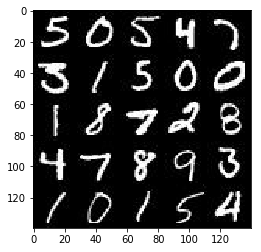

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#
# The following line is modified to avoid an error with the original one. Convert the images to numpy array.
#
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

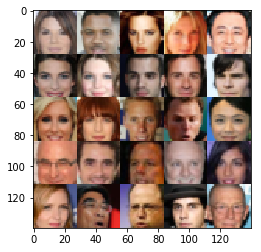

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate= tf.placeholder(tf.float32, (), name= 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [3]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha= 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1= tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1= tf.maximum(alpha * x1, x1)
        # 14x14x64
        x2= tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2= tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        x3= tf.layers.conv2d(relu2, 256, 5, strides=2,  padding='same')
        bn3= tf.layers.batch_normalization(x3, training=True)
        relu3= tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        flat= tf.reshape(relu3, (-1, 4*4*256))
        logits= tf.layers.dense(flat, 1)
        out= tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha= 0.01
    reuse= not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1= tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1= tf.reshape(x1, (-1, 7, 7, 512))
        x1= tf.layers.batch_normalization(x1, training=is_train)
        x1= tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2= tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2= tf.layers.batch_normalization(x2, training=is_train)
        x2= tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3= tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3= tf.layers.batch_normalization(x3, training=is_train)
        x3= tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits= tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out= tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [5]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model= generator(input_z, out_channel_dim)
    d_model_real, d_logits_real= discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake= discriminator(g_model, reuse=True)
    
    d_loss_real= tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(
                    logits= d_logits_real, 
                    labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(
                    logits= d_logits_fake, 
                    labels= tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(
                    logits= d_logits_fake, 
                    labels= tf.ones_like(d_model_fake)))
    
    d_loss= d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 10 Discriminator Loss: 0.0379... Generator Loss: 9.4688
Epoch 1/2..., step 20 Discriminator Loss: 0.1451... Generator Loss: 2.3580
Epoch 1/2..., step 30 Discriminator Loss: 0.0267... Generator Loss: 17.6642
Epoch 1/2..., step 40 Discriminator Loss: 0.0008... Generator Loss: 9.5120
Epoch 1/2..., step 50 Discriminator Loss: 0.2331... Generator Loss: 2.9277
Epoch 1/2..., step 60 Discriminator Loss: 0.0334... Generator Loss: 6.6207
Epoch 1/2..., step 70 Discriminator Loss: 0.0591... Generator Loss: 4.4604
Epoch 1/2..., step 80 Discriminator Loss: 0.0806... Generator Loss: 4.0545
Epoch 1/2..., step 90 Discriminator Loss: 0.4338... Generator Loss: 2.2963
Epoch 1/2..., step 100 Discriminator Loss: 0.4213... Generator Loss: 1.7607


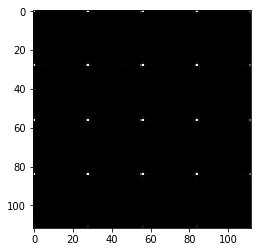

Epoch 1/2..., step 110 Discriminator Loss: 1.1083... Generator Loss: 2.4413
Epoch 1/2..., step 120 Discriminator Loss: 2.6988... Generator Loss: 5.8213
Epoch 1/2..., step 130 Discriminator Loss: 1.8812... Generator Loss: 0.3316
Epoch 1/2..., step 140 Discriminator Loss: 1.2287... Generator Loss: 0.7895
Epoch 1/2..., step 150 Discriminator Loss: 1.4683... Generator Loss: 2.1453
Epoch 1/2..., step 160 Discriminator Loss: 0.5889... Generator Loss: 2.7566
Epoch 1/2..., step 170 Discriminator Loss: 1.1138... Generator Loss: 1.0215
Epoch 1/2..., step 180 Discriminator Loss: 1.4823... Generator Loss: 1.9452
Epoch 1/2..., step 190 Discriminator Loss: 1.1921... Generator Loss: 0.5674
Epoch 1/2..., step 200 Discriminator Loss: 1.1787... Generator Loss: 0.6338


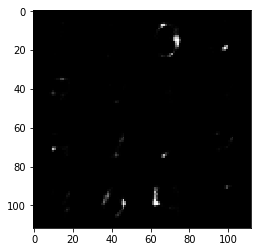

Epoch 1/2..., step 210 Discriminator Loss: 1.6449... Generator Loss: 0.3295
Epoch 1/2..., step 220 Discriminator Loss: 1.0876... Generator Loss: 0.7374
Epoch 1/2..., step 230 Discriminator Loss: 1.0415... Generator Loss: 1.4612
Epoch 1/2..., step 240 Discriminator Loss: 1.1625... Generator Loss: 0.6673
Epoch 1/2..., step 250 Discriminator Loss: 1.4199... Generator Loss: 0.4551
Epoch 1/2..., step 260 Discriminator Loss: 1.2344... Generator Loss: 0.6057
Epoch 1/2..., step 270 Discriminator Loss: 1.0440... Generator Loss: 1.7307
Epoch 1/2..., step 280 Discriminator Loss: 0.9429... Generator Loss: 0.9690
Epoch 1/2..., step 290 Discriminator Loss: 1.2086... Generator Loss: 0.5905
Epoch 1/2..., step 300 Discriminator Loss: 0.9989... Generator Loss: 0.7776


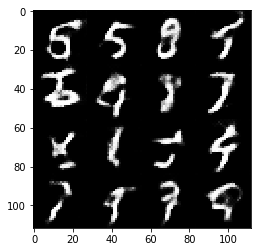

Epoch 1/2..., step 310 Discriminator Loss: 0.8814... Generator Loss: 1.5958
Epoch 1/2..., step 320 Discriminator Loss: 0.9570... Generator Loss: 1.2998
Epoch 1/2..., step 330 Discriminator Loss: 0.9534... Generator Loss: 1.5465
Epoch 1/2..., step 340 Discriminator Loss: 1.0384... Generator Loss: 0.9868
Epoch 1/2..., step 350 Discriminator Loss: 0.9851... Generator Loss: 0.8371
Epoch 1/2..., step 360 Discriminator Loss: 1.2880... Generator Loss: 0.5047
Epoch 1/2..., step 370 Discriminator Loss: 1.0287... Generator Loss: 1.0183
Epoch 1/2..., step 380 Discriminator Loss: 1.1715... Generator Loss: 0.6973
Epoch 1/2..., step 390 Discriminator Loss: 1.2513... Generator Loss: 1.2155
Epoch 1/2..., step 400 Discriminator Loss: 1.1568... Generator Loss: 0.6912


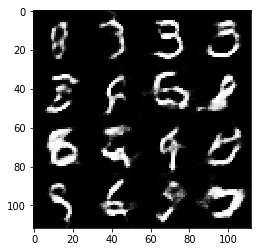

Epoch 1/2..., step 410 Discriminator Loss: 1.0788... Generator Loss: 0.7641
Epoch 1/2..., step 420 Discriminator Loss: 1.2712... Generator Loss: 0.7552
Epoch 1/2..., step 430 Discriminator Loss: 0.9639... Generator Loss: 0.9142
Epoch 1/2..., step 440 Discriminator Loss: 1.1778... Generator Loss: 1.4614
Epoch 1/2..., step 450 Discriminator Loss: 1.1546... Generator Loss: 0.9647
Epoch 1/2..., step 460 Discriminator Loss: 1.3978... Generator Loss: 0.3861
Epoch 1/2..., step 470 Discriminator Loss: 1.0702... Generator Loss: 0.9150
Epoch 1/2..., step 480 Discriminator Loss: 1.3180... Generator Loss: 0.5192
Epoch 1/2..., step 490 Discriminator Loss: 1.1907... Generator Loss: 0.6302
Epoch 1/2..., step 500 Discriminator Loss: 1.5396... Generator Loss: 0.3311


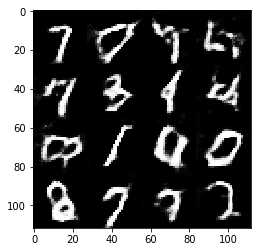

Epoch 1/2..., step 510 Discriminator Loss: 1.2866... Generator Loss: 0.4985
Epoch 1/2..., step 520 Discriminator Loss: 1.0429... Generator Loss: 0.8813
Epoch 1/2..., step 530 Discriminator Loss: 1.4400... Generator Loss: 0.4312
Epoch 1/2..., step 540 Discriminator Loss: 1.1524... Generator Loss: 0.9920
Epoch 1/2..., step 550 Discriminator Loss: 1.1020... Generator Loss: 0.6910
Epoch 1/2..., step 560 Discriminator Loss: 1.3354... Generator Loss: 0.4174
Epoch 1/2..., step 570 Discriminator Loss: 0.9948... Generator Loss: 1.3286
Epoch 1/2..., step 580 Discriminator Loss: 1.0821... Generator Loss: 0.8211
Epoch 1/2..., step 590 Discriminator Loss: 1.0089... Generator Loss: 1.0116
Epoch 1/2..., step 600 Discriminator Loss: 1.0703... Generator Loss: 1.1536


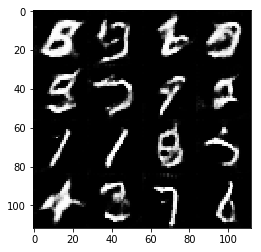

Epoch 1/2..., step 610 Discriminator Loss: 0.9829... Generator Loss: 1.0279
Epoch 1/2..., step 620 Discriminator Loss: 1.4257... Generator Loss: 0.4572
Epoch 1/2..., step 630 Discriminator Loss: 1.0510... Generator Loss: 0.7788
Epoch 1/2..., step 640 Discriminator Loss: 1.1508... Generator Loss: 0.6345
Epoch 1/2..., step 650 Discriminator Loss: 1.0854... Generator Loss: 0.6822
Epoch 1/2..., step 660 Discriminator Loss: 1.2457... Generator Loss: 0.5452
Epoch 1/2..., step 670 Discriminator Loss: 1.0666... Generator Loss: 0.7613
Epoch 1/2..., step 680 Discriminator Loss: 1.0481... Generator Loss: 1.2251
Epoch 1/2..., step 690 Discriminator Loss: 1.1319... Generator Loss: 1.4758
Epoch 1/2..., step 700 Discriminator Loss: 1.2111... Generator Loss: 0.6153


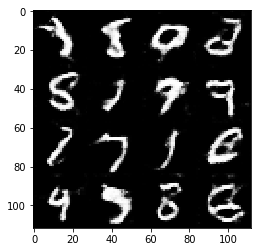

Epoch 1/2..., step 710 Discriminator Loss: 1.1598... Generator Loss: 0.5179
Epoch 1/2..., step 720 Discriminator Loss: 0.9915... Generator Loss: 0.7323
Epoch 1/2..., step 730 Discriminator Loss: 0.8588... Generator Loss: 1.1216
Epoch 1/2..., step 740 Discriminator Loss: 1.5983... Generator Loss: 0.3621
Epoch 1/2..., step 750 Discriminator Loss: 1.1043... Generator Loss: 1.6837
Epoch 1/2..., step 760 Discriminator Loss: 1.1396... Generator Loss: 0.6126
Epoch 1/2..., step 770 Discriminator Loss: 1.2107... Generator Loss: 0.6579
Epoch 1/2..., step 780 Discriminator Loss: 1.4106... Generator Loss: 0.3701
Epoch 1/2..., step 790 Discriminator Loss: 0.9261... Generator Loss: 1.1110
Epoch 1/2..., step 800 Discriminator Loss: 1.5101... Generator Loss: 0.3785


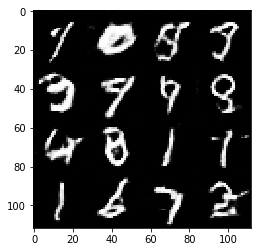

Epoch 1/2..., step 810 Discriminator Loss: 1.0477... Generator Loss: 0.8435
Epoch 1/2..., step 820 Discriminator Loss: 0.8453... Generator Loss: 0.8877
Epoch 1/2..., step 830 Discriminator Loss: 1.2519... Generator Loss: 0.5692
Epoch 1/2..., step 840 Discriminator Loss: 1.0789... Generator Loss: 0.6428
Epoch 1/2..., step 850 Discriminator Loss: 1.3064... Generator Loss: 0.6158
Epoch 1/2..., step 860 Discriminator Loss: 1.2976... Generator Loss: 0.4769
Epoch 1/2..., step 870 Discriminator Loss: 0.9813... Generator Loss: 0.8235
Epoch 1/2..., step 880 Discriminator Loss: 1.2206... Generator Loss: 0.5141
Epoch 1/2..., step 890 Discriminator Loss: 0.9515... Generator Loss: 0.8171
Epoch 1/2..., step 900 Discriminator Loss: 0.7237... Generator Loss: 1.4490


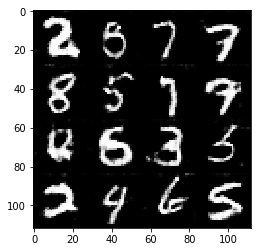

Epoch 1/2..., step 910 Discriminator Loss: 1.3963... Generator Loss: 0.4407
Epoch 1/2..., step 920 Discriminator Loss: 1.0658... Generator Loss: 0.7179
Epoch 1/2..., step 930 Discriminator Loss: 0.8673... Generator Loss: 1.6473
Epoch 2/2..., step 940 Discriminator Loss: 1.9362... Generator Loss: 0.2398
Epoch 2/2..., step 950 Discriminator Loss: 1.0534... Generator Loss: 0.6550
Epoch 2/2..., step 960 Discriminator Loss: 1.0984... Generator Loss: 0.6459
Epoch 2/2..., step 970 Discriminator Loss: 0.8930... Generator Loss: 0.9813
Epoch 2/2..., step 980 Discriminator Loss: 1.0436... Generator Loss: 1.0203
Epoch 2/2..., step 990 Discriminator Loss: 1.2305... Generator Loss: 0.6418
Epoch 2/2..., step 1000 Discriminator Loss: 1.1829... Generator Loss: 0.5779


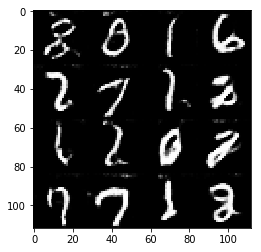

Epoch 2/2..., step 1010 Discriminator Loss: 0.7200... Generator Loss: 1.4387
Epoch 2/2..., step 1020 Discriminator Loss: 1.1066... Generator Loss: 0.8469
Epoch 2/2..., step 1030 Discriminator Loss: 1.1411... Generator Loss: 0.5889
Epoch 2/2..., step 1040 Discriminator Loss: 1.0319... Generator Loss: 0.6546
Epoch 2/2..., step 1050 Discriminator Loss: 0.8579... Generator Loss: 1.2363
Epoch 2/2..., step 1060 Discriminator Loss: 0.9863... Generator Loss: 0.7434
Epoch 2/2..., step 1070 Discriminator Loss: 1.1579... Generator Loss: 0.6320
Epoch 2/2..., step 1080 Discriminator Loss: 2.1271... Generator Loss: 0.2040
Epoch 2/2..., step 1090 Discriminator Loss: 0.7357... Generator Loss: 1.1031
Epoch 2/2..., step 1100 Discriminator Loss: 0.6217... Generator Loss: 1.4662


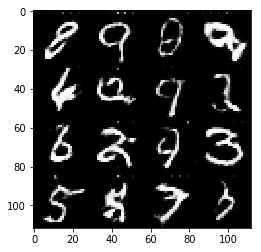

Epoch 2/2..., step 1110 Discriminator Loss: 1.1672... Generator Loss: 0.5770
Epoch 2/2..., step 1120 Discriminator Loss: 0.7927... Generator Loss: 0.9916
Epoch 2/2..., step 1130 Discriminator Loss: 1.4038... Generator Loss: 0.4177
Epoch 2/2..., step 1140 Discriminator Loss: 0.9534... Generator Loss: 0.7797
Epoch 2/2..., step 1150 Discriminator Loss: 0.7815... Generator Loss: 1.4929
Epoch 2/2..., step 1160 Discriminator Loss: 1.4084... Generator Loss: 0.4067
Epoch 2/2..., step 1170 Discriminator Loss: 0.7719... Generator Loss: 1.0632
Epoch 2/2..., step 1180 Discriminator Loss: 1.0788... Generator Loss: 0.6534
Epoch 2/2..., step 1190 Discriminator Loss: 0.8119... Generator Loss: 0.9978
Epoch 2/2..., step 1200 Discriminator Loss: 0.6576... Generator Loss: 2.4291


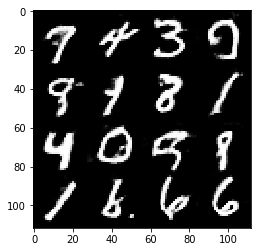

Epoch 2/2..., step 1210 Discriminator Loss: 0.8922... Generator Loss: 1.0557
Epoch 2/2..., step 1220 Discriminator Loss: 0.9490... Generator Loss: 0.8221
Epoch 2/2..., step 1230 Discriminator Loss: 1.0070... Generator Loss: 1.0057
Epoch 2/2..., step 1240 Discriminator Loss: 0.9155... Generator Loss: 0.9256
Epoch 2/2..., step 1250 Discriminator Loss: 0.6718... Generator Loss: 1.0823
Epoch 2/2..., step 1260 Discriminator Loss: 0.7125... Generator Loss: 1.1987
Epoch 2/2..., step 1270 Discriminator Loss: 1.2698... Generator Loss: 0.5714
Epoch 2/2..., step 1280 Discriminator Loss: 1.1744... Generator Loss: 0.5913
Epoch 2/2..., step 1290 Discriminator Loss: 1.6599... Generator Loss: 0.3738
Epoch 2/2..., step 1300 Discriminator Loss: 1.0250... Generator Loss: 0.6183


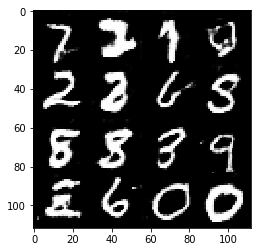

Epoch 2/2..., step 1310 Discriminator Loss: 1.2530... Generator Loss: 0.5183
Epoch 2/2..., step 1320 Discriminator Loss: 0.9857... Generator Loss: 0.9689
Epoch 2/2..., step 1330 Discriminator Loss: 0.7378... Generator Loss: 1.2384
Epoch 2/2..., step 1340 Discriminator Loss: 1.1915... Generator Loss: 0.5706
Epoch 2/2..., step 1350 Discriminator Loss: 0.8437... Generator Loss: 1.9938
Epoch 2/2..., step 1360 Discriminator Loss: 0.9979... Generator Loss: 0.7735
Epoch 2/2..., step 1370 Discriminator Loss: 0.8547... Generator Loss: 0.8767
Epoch 2/2..., step 1380 Discriminator Loss: 0.8606... Generator Loss: 0.9221
Epoch 2/2..., step 1390 Discriminator Loss: 0.9771... Generator Loss: 0.8178
Epoch 2/2..., step 1400 Discriminator Loss: 1.5895... Generator Loss: 0.3539


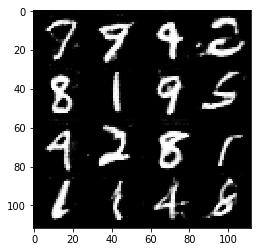

Epoch 2/2..., step 1410 Discriminator Loss: 0.7854... Generator Loss: 1.2880
Epoch 2/2..., step 1420 Discriminator Loss: 1.5549... Generator Loss: 0.4236
Epoch 2/2..., step 1430 Discriminator Loss: 0.9831... Generator Loss: 0.8944
Epoch 2/2..., step 1440 Discriminator Loss: 0.8866... Generator Loss: 1.0072
Epoch 2/2..., step 1450 Discriminator Loss: 0.7483... Generator Loss: 1.8376
Epoch 2/2..., step 1460 Discriminator Loss: 0.7612... Generator Loss: 1.9558
Epoch 2/2..., step 1470 Discriminator Loss: 0.4560... Generator Loss: 1.7737
Epoch 2/2..., step 1480 Discriminator Loss: 0.7192... Generator Loss: 2.4416
Epoch 2/2..., step 1490 Discriminator Loss: 0.6150... Generator Loss: 2.2530
Epoch 2/2..., step 1500 Discriminator Loss: 1.0061... Generator Loss: 1.0637


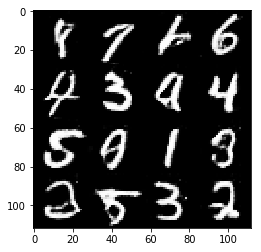

Epoch 2/2..., step 1510 Discriminator Loss: 1.2994... Generator Loss: 0.4951
Epoch 2/2..., step 1520 Discriminator Loss: 1.5613... Generator Loss: 0.4286
Epoch 2/2..., step 1530 Discriminator Loss: 0.8456... Generator Loss: 0.8714
Epoch 2/2..., step 1540 Discriminator Loss: 1.0036... Generator Loss: 0.8120
Epoch 2/2..., step 1550 Discriminator Loss: 1.7228... Generator Loss: 0.3173
Epoch 2/2..., step 1560 Discriminator Loss: 0.7637... Generator Loss: 1.3901
Epoch 2/2..., step 1570 Discriminator Loss: 1.6729... Generator Loss: 0.3244
Epoch 2/2..., step 1580 Discriminator Loss: 1.0074... Generator Loss: 0.8665
Epoch 2/2..., step 1590 Discriminator Loss: 0.6480... Generator Loss: 1.7299
Epoch 2/2..., step 1600 Discriminator Loss: 1.4155... Generator Loss: 0.4303


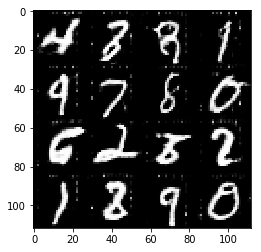

Epoch 2/2..., step 1610 Discriminator Loss: 0.7537... Generator Loss: 1.6168
Epoch 2/2..., step 1620 Discriminator Loss: 0.7924... Generator Loss: 1.0461
Epoch 2/2..., step 1630 Discriminator Loss: 0.8903... Generator Loss: 0.8090
Epoch 2/2..., step 1640 Discriminator Loss: 0.9935... Generator Loss: 1.5233
Epoch 2/2..., step 1650 Discriminator Loss: 1.0552... Generator Loss: 0.7291
Epoch 2/2..., step 1660 Discriminator Loss: 0.8544... Generator Loss: 0.8839
Epoch 2/2..., step 1670 Discriminator Loss: 1.5572... Generator Loss: 0.3949
Epoch 2/2..., step 1680 Discriminator Loss: 0.7080... Generator Loss: 1.6338
Epoch 2/2..., step 1690 Discriminator Loss: 0.5578... Generator Loss: 1.4830
Epoch 2/2..., step 1700 Discriminator Loss: 0.7988... Generator Loss: 1.1881


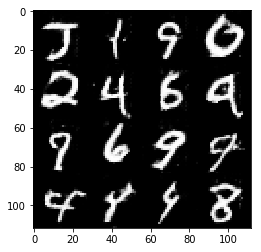

Epoch 2/2..., step 1710 Discriminator Loss: 0.9252... Generator Loss: 0.7310
Epoch 2/2..., step 1720 Discriminator Loss: 0.9223... Generator Loss: 0.8443
Epoch 2/2..., step 1730 Discriminator Loss: 1.4574... Generator Loss: 0.4002
Epoch 2/2..., step 1740 Discriminator Loss: 0.5647... Generator Loss: 1.4741
Epoch 2/2..., step 1750 Discriminator Loss: 0.5773... Generator Loss: 2.1873
Epoch 2/2..., step 1760 Discriminator Loss: 0.8867... Generator Loss: 1.5792
Epoch 2/2..., step 1770 Discriminator Loss: 0.8432... Generator Loss: 1.0399
Epoch 2/2..., step 1780 Discriminator Loss: 1.0823... Generator Loss: 0.7518
Epoch 2/2..., step 1790 Discriminator Loss: 0.7678... Generator Loss: 1.1813
Epoch 2/2..., step 1800 Discriminator Loss: 0.9324... Generator Loss: 3.0499


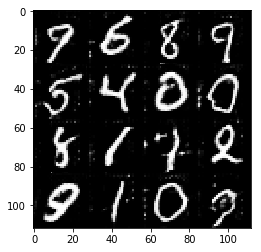

Epoch 2/2..., step 1810 Discriminator Loss: 1.3090... Generator Loss: 0.5046
Epoch 2/2..., step 1820 Discriminator Loss: 0.7986... Generator Loss: 0.9307
Epoch 2/2..., step 1830 Discriminator Loss: 1.1977... Generator Loss: 0.5903
Epoch 2/2..., step 1840 Discriminator Loss: 0.6523... Generator Loss: 1.5048
Epoch 2/2..., step 1850 Discriminator Loss: 0.5113... Generator Loss: 1.4937
Epoch 2/2..., step 1860 Discriminator Loss: 0.8496... Generator Loss: 0.9493
Epoch 2/2..., step 1870 Discriminator Loss: 0.5688... Generator Loss: 2.1131


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1..., step 10 Discriminator Loss: 1.0648... Generator Loss: 0.6941
Epoch 1/1..., step 20 Discriminator Loss: 0.7826... Generator Loss: 1.0381
Epoch 1/1..., step 30 Discriminator Loss: 0.6820... Generator Loss: 1.0076
Epoch 1/1..., step 40 Discriminator Loss: 0.7735... Generator Loss: 0.9511
Epoch 1/1..., step 50 Discriminator Loss: 0.4378... Generator Loss: 1.5494
Epoch 1/1..., step 60 Discriminator Loss: 0.8651... Generator Loss: 0.9373
Epoch 1/1..., step 70 Discriminator Loss: 0.4240... Generator Loss: 1.7190
Epoch 1/1..., step 80 Discriminator Loss: 0.9059... Generator Loss: 0.7566
Epoch 1/1..., step 90 Discriminator Loss: 0.7686... Generator Loss: 0.9857
Epoch 1/1..., step 100 Discriminator Loss: 0.5893... Generator Loss: 2.8365


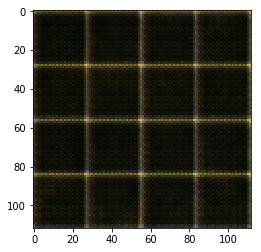

Epoch 1/1..., step 110 Discriminator Loss: 0.6868... Generator Loss: 0.9917
Epoch 1/1..., step 120 Discriminator Loss: 0.4723... Generator Loss: 1.7059
Epoch 1/1..., step 130 Discriminator Loss: 1.3278... Generator Loss: 5.3150
Epoch 1/1..., step 140 Discriminator Loss: 0.6776... Generator Loss: 1.1281
Epoch 1/1..., step 150 Discriminator Loss: 0.6755... Generator Loss: 1.1805
Epoch 1/1..., step 160 Discriminator Loss: 0.2894... Generator Loss: 3.2908
Epoch 1/1..., step 170 Discriminator Loss: 1.2259... Generator Loss: 0.5244
Epoch 1/1..., step 180 Discriminator Loss: 0.5268... Generator Loss: 1.3030
Epoch 1/1..., step 190 Discriminator Loss: 0.3210... Generator Loss: 2.5927
Epoch 1/1..., step 200 Discriminator Loss: 0.3452... Generator Loss: 3.6244


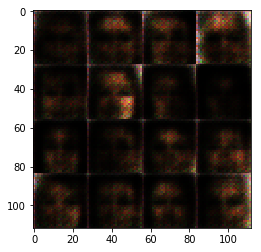

Epoch 1/1..., step 210 Discriminator Loss: 0.4948... Generator Loss: 3.5994
Epoch 1/1..., step 220 Discriminator Loss: 0.4925... Generator Loss: 2.6283
Epoch 1/1..., step 230 Discriminator Loss: 0.9323... Generator Loss: 0.7090
Epoch 1/1..., step 240 Discriminator Loss: 0.7059... Generator Loss: 0.9984
Epoch 1/1..., step 250 Discriminator Loss: 0.3086... Generator Loss: 3.7429
Epoch 1/1..., step 260 Discriminator Loss: 0.3520... Generator Loss: 1.8007
Epoch 1/1..., step 270 Discriminator Loss: 0.3123... Generator Loss: 2.4600
Epoch 1/1..., step 280 Discriminator Loss: 0.8471... Generator Loss: 0.8650
Epoch 1/1..., step 290 Discriminator Loss: 0.8090... Generator Loss: 0.8557
Epoch 1/1..., step 300 Discriminator Loss: 1.0966... Generator Loss: 0.5186


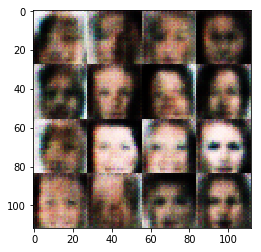

Epoch 1/1..., step 310 Discriminator Loss: 0.3453... Generator Loss: 2.2981
Epoch 1/1..., step 320 Discriminator Loss: 0.1743... Generator Loss: 2.6855
Epoch 1/1..., step 330 Discriminator Loss: 0.1741... Generator Loss: 3.4668
Epoch 1/1..., step 340 Discriminator Loss: 0.4470... Generator Loss: 2.1639
Epoch 1/1..., step 350 Discriminator Loss: 0.3800... Generator Loss: 2.1812
Epoch 1/1..., step 360 Discriminator Loss: 1.0216... Generator Loss: 0.7270
Epoch 1/1..., step 370 Discriminator Loss: 0.3255... Generator Loss: 2.2500
Epoch 1/1..., step 380 Discriminator Loss: 0.3944... Generator Loss: 2.3393
Epoch 1/1..., step 390 Discriminator Loss: 0.7010... Generator Loss: 1.1768
Epoch 1/1..., step 400 Discriminator Loss: 0.3578... Generator Loss: 1.5437


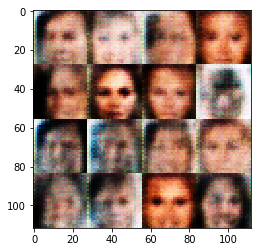

Epoch 1/1..., step 410 Discriminator Loss: 0.3802... Generator Loss: 2.9125
Epoch 1/1..., step 420 Discriminator Loss: 1.0056... Generator Loss: 0.6769
Epoch 1/1..., step 430 Discriminator Loss: 0.9466... Generator Loss: 0.8318
Epoch 1/1..., step 440 Discriminator Loss: 0.1632... Generator Loss: 2.4672
Epoch 1/1..., step 450 Discriminator Loss: 1.0595... Generator Loss: 2.5041
Epoch 1/1..., step 460 Discriminator Loss: 0.2916... Generator Loss: 1.9717
Epoch 1/1..., step 470 Discriminator Loss: 0.1977... Generator Loss: 2.7066
Epoch 1/1..., step 480 Discriminator Loss: 1.2359... Generator Loss: 0.6111
Epoch 1/1..., step 490 Discriminator Loss: 0.9362... Generator Loss: 0.7395
Epoch 1/1..., step 500 Discriminator Loss: 0.8287... Generator Loss: 0.9568


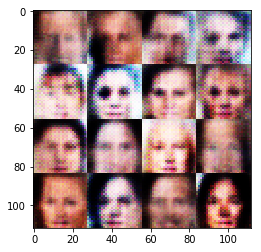

Epoch 1/1..., step 510 Discriminator Loss: 0.8120... Generator Loss: 1.1446
Epoch 1/1..., step 520 Discriminator Loss: 0.2477... Generator Loss: 2.2206
Epoch 1/1..., step 530 Discriminator Loss: 0.4063... Generator Loss: 1.4622
Epoch 1/1..., step 540 Discriminator Loss: 0.5069... Generator Loss: 2.8397
Epoch 1/1..., step 550 Discriminator Loss: 0.6254... Generator Loss: 2.0277
Epoch 1/1..., step 560 Discriminator Loss: 0.3840... Generator Loss: 1.5793
Epoch 1/1..., step 570 Discriminator Loss: 0.2726... Generator Loss: 2.4326
Epoch 1/1..., step 580 Discriminator Loss: 0.9511... Generator Loss: 0.7376
Epoch 1/1..., step 590 Discriminator Loss: 0.4559... Generator Loss: 2.5817
Epoch 1/1..., step 600 Discriminator Loss: 1.2137... Generator Loss: 0.4889


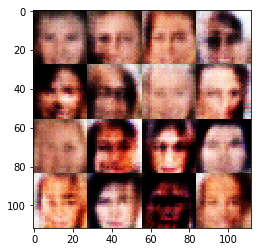

Epoch 1/1..., step 610 Discriminator Loss: 0.2969... Generator Loss: 2.1142
Epoch 1/1..., step 620 Discriminator Loss: 0.8738... Generator Loss: 0.7916
Epoch 1/1..., step 630 Discriminator Loss: 0.9857... Generator Loss: 2.3555
Epoch 1/1..., step 640 Discriminator Loss: 0.1908... Generator Loss: 2.6542
Epoch 1/1..., step 650 Discriminator Loss: 0.8033... Generator Loss: 0.8416
Epoch 1/1..., step 660 Discriminator Loss: 0.2237... Generator Loss: 3.1120
Epoch 1/1..., step 670 Discriminator Loss: 0.3502... Generator Loss: 2.1098
Epoch 1/1..., step 680 Discriminator Loss: 0.5774... Generator Loss: 2.6044
Epoch 1/1..., step 690 Discriminator Loss: 0.5122... Generator Loss: 1.3439
Epoch 1/1..., step 700 Discriminator Loss: 0.6290... Generator Loss: 2.5751


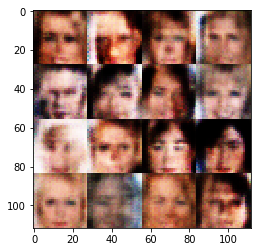

Epoch 1/1..., step 710 Discriminator Loss: 0.4579... Generator Loss: 3.8275
Epoch 1/1..., step 720 Discriminator Loss: 0.7187... Generator Loss: 0.9920
Epoch 1/1..., step 730 Discriminator Loss: 1.1783... Generator Loss: 0.8051
Epoch 1/1..., step 740 Discriminator Loss: 0.8787... Generator Loss: 0.7912
Epoch 1/1..., step 750 Discriminator Loss: 0.3728... Generator Loss: 3.1579
Epoch 1/1..., step 760 Discriminator Loss: 0.9198... Generator Loss: 0.9459
Epoch 1/1..., step 770 Discriminator Loss: 0.4188... Generator Loss: 1.9821
Epoch 1/1..., step 780 Discriminator Loss: 0.1858... Generator Loss: 3.9359
Epoch 1/1..., step 790 Discriminator Loss: 0.3144... Generator Loss: 2.8987
Epoch 1/1..., step 800 Discriminator Loss: 0.3072... Generator Loss: 2.0322


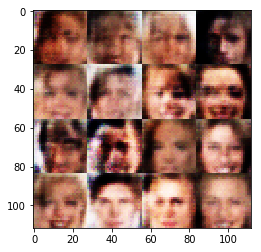

Epoch 1/1..., step 810 Discriminator Loss: 0.2446... Generator Loss: 2.3849
Epoch 1/1..., step 820 Discriminator Loss: 0.1235... Generator Loss: 4.2243
Epoch 1/1..., step 830 Discriminator Loss: 0.3186... Generator Loss: 3.9658
Epoch 1/1..., step 840 Discriminator Loss: 1.2463... Generator Loss: 0.4930
Epoch 1/1..., step 850 Discriminator Loss: 0.6850... Generator Loss: 1.1214
Epoch 1/1..., step 860 Discriminator Loss: 0.2335... Generator Loss: 2.1997
Epoch 1/1..., step 870 Discriminator Loss: 0.4028... Generator Loss: 1.4857
Epoch 1/1..., step 880 Discriminator Loss: 0.8406... Generator Loss: 1.6624
Epoch 1/1..., step 890 Discriminator Loss: 0.6862... Generator Loss: 1.1534
Epoch 1/1..., step 900 Discriminator Loss: 0.4997... Generator Loss: 2.5802


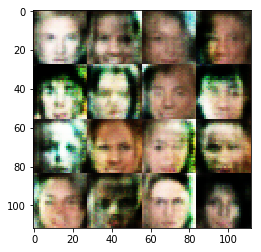

Epoch 1/1..., step 910 Discriminator Loss: 0.5751... Generator Loss: 1.1940
Epoch 1/1..., step 920 Discriminator Loss: 0.8886... Generator Loss: 2.8312
Epoch 1/1..., step 930 Discriminator Loss: 0.2845... Generator Loss: 2.1689
Epoch 1/1..., step 940 Discriminator Loss: 0.4203... Generator Loss: 2.1885
Epoch 1/1..., step 950 Discriminator Loss: 0.6456... Generator Loss: 6.4129
Epoch 1/1..., step 960 Discriminator Loss: 0.3709... Generator Loss: 1.9794
Epoch 1/1..., step 970 Discriminator Loss: 0.3362... Generator Loss: 3.2614
Epoch 1/1..., step 980 Discriminator Loss: 0.2859... Generator Loss: 2.1546
Epoch 1/1..., step 990 Discriminator Loss: 0.1332... Generator Loss: 3.9668
Epoch 1/1..., step 1000 Discriminator Loss: 1.1286... Generator Loss: 3.3465


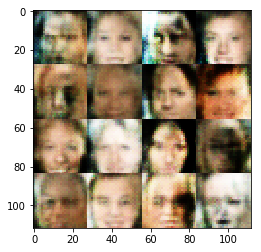

Epoch 1/1..., step 1010 Discriminator Loss: 1.2390... Generator Loss: 0.6818
Epoch 1/1..., step 1020 Discriminator Loss: 0.4411... Generator Loss: 1.7981
Epoch 1/1..., step 1030 Discriminator Loss: 0.9092... Generator Loss: 0.7467
Epoch 1/1..., step 1040 Discriminator Loss: 0.5505... Generator Loss: 1.5140
Epoch 1/1..., step 1050 Discriminator Loss: 0.5661... Generator Loss: 1.4304
Epoch 1/1..., step 1060 Discriminator Loss: 1.1186... Generator Loss: 0.5314
Epoch 1/1..., step 1070 Discriminator Loss: 0.2190... Generator Loss: 2.3349
Epoch 1/1..., step 1080 Discriminator Loss: 0.4487... Generator Loss: 1.5432
Epoch 1/1..., step 1090 Discriminator Loss: 0.5385... Generator Loss: 1.2272
Epoch 1/1..., step 1100 Discriminator Loss: 1.0892... Generator Loss: 0.5351


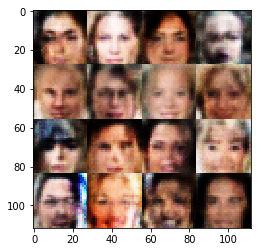

Epoch 1/1..., step 1110 Discriminator Loss: 1.5094... Generator Loss: 0.3566
Epoch 1/1..., step 1120 Discriminator Loss: 0.7161... Generator Loss: 0.9246
Epoch 1/1..., step 1130 Discriminator Loss: 0.5552... Generator Loss: 1.2165
Epoch 1/1..., step 1140 Discriminator Loss: 0.3005... Generator Loss: 2.0801
Epoch 1/1..., step 1150 Discriminator Loss: 0.5030... Generator Loss: 1.3746
Epoch 1/1..., step 1160 Discriminator Loss: 0.4556... Generator Loss: 1.4261
Epoch 1/1..., step 1170 Discriminator Loss: 0.2678... Generator Loss: 4.0101
Epoch 1/1..., step 1180 Discriminator Loss: 0.2617... Generator Loss: 2.4760
Epoch 1/1..., step 1190 Discriminator Loss: 0.2189... Generator Loss: 2.7771
Epoch 1/1..., step 1200 Discriminator Loss: 0.5967... Generator Loss: 3.9545


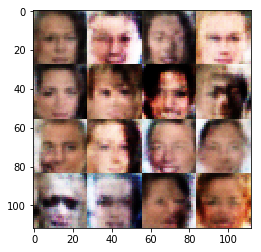

Epoch 1/1..., step 1210 Discriminator Loss: 0.2858... Generator Loss: 2.0654
Epoch 1/1..., step 1220 Discriminator Loss: 0.5629... Generator Loss: 1.2776
Epoch 1/1..., step 1230 Discriminator Loss: 0.5579... Generator Loss: 1.1037
Epoch 1/1..., step 1240 Discriminator Loss: 0.5226... Generator Loss: 1.1589
Epoch 1/1..., step 1250 Discriminator Loss: 0.5343... Generator Loss: 3.7599
Epoch 1/1..., step 1260 Discriminator Loss: 0.2871... Generator Loss: 2.0149
Epoch 1/1..., step 1270 Discriminator Loss: 0.7741... Generator Loss: 0.8937
Epoch 1/1..., step 1280 Discriminator Loss: 0.4732... Generator Loss: 1.3601
Epoch 1/1..., step 1290 Discriminator Loss: 0.5600... Generator Loss: 1.1665
Epoch 1/1..., step 1300 Discriminator Loss: 0.1903... Generator Loss: 3.0342


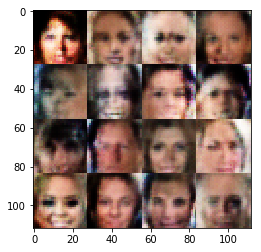

Epoch 1/1..., step 1310 Discriminator Loss: 0.4274... Generator Loss: 1.4257
Epoch 1/1..., step 1320 Discriminator Loss: 3.1856... Generator Loss: 0.0805
Epoch 1/1..., step 1330 Discriminator Loss: 0.3998... Generator Loss: 4.4031
Epoch 1/1..., step 1340 Discriminator Loss: 0.3652... Generator Loss: 1.7771
Epoch 1/1..., step 1350 Discriminator Loss: 0.2746... Generator Loss: 2.8357
Epoch 1/1..., step 1360 Discriminator Loss: 0.2481... Generator Loss: 2.9475
Epoch 1/1..., step 1370 Discriminator Loss: 0.4238... Generator Loss: 4.7577
Epoch 1/1..., step 1380 Discriminator Loss: 0.4443... Generator Loss: 2.7722
Epoch 1/1..., step 1390 Discriminator Loss: 0.7954... Generator Loss: 1.7366
Epoch 1/1..., step 1400 Discriminator Loss: 0.3507... Generator Loss: 1.7621


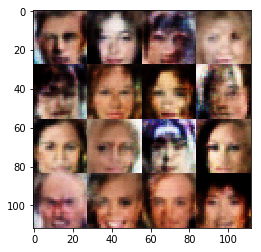

Epoch 1/1..., step 1410 Discriminator Loss: 0.1829... Generator Loss: 3.7753
Epoch 1/1..., step 1420 Discriminator Loss: 0.3561... Generator Loss: 2.9786
Epoch 1/1..., step 1430 Discriminator Loss: 0.3554... Generator Loss: 3.3925
Epoch 1/1..., step 1440 Discriminator Loss: 0.5057... Generator Loss: 1.6240
Epoch 1/1..., step 1450 Discriminator Loss: 0.0634... Generator Loss: 3.4112
Epoch 1/1..., step 1460 Discriminator Loss: 0.4314... Generator Loss: 1.7287
Epoch 1/1..., step 1470 Discriminator Loss: 0.1822... Generator Loss: 2.5185
Epoch 1/1..., step 1480 Discriminator Loss: 0.2477... Generator Loss: 6.4877
Epoch 1/1..., step 1490 Discriminator Loss: 2.0965... Generator Loss: 0.3142
Epoch 1/1..., step 1500 Discriminator Loss: 0.6113... Generator Loss: 1.7859


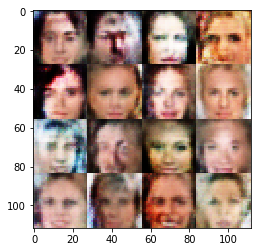

Epoch 1/1..., step 1510 Discriminator Loss: 0.4856... Generator Loss: 1.5744
Epoch 1/1..., step 1520 Discriminator Loss: 0.2489... Generator Loss: 2.5497
Epoch 1/1..., step 1530 Discriminator Loss: 0.2964... Generator Loss: 2.3498
Epoch 1/1..., step 1540 Discriminator Loss: 0.7893... Generator Loss: 5.8700
Epoch 1/1..., step 1550 Discriminator Loss: 0.2314... Generator Loss: 3.0642
Epoch 1/1..., step 1560 Discriminator Loss: 0.1492... Generator Loss: 3.2538
Epoch 1/1..., step 1570 Discriminator Loss: 0.2328... Generator Loss: 2.6289
Epoch 1/1..., step 1580 Discriminator Loss: 0.2563... Generator Loss: 2.5211
Epoch 1/1..., step 1590 Discriminator Loss: 1.0601... Generator Loss: 0.5574
Epoch 1/1..., step 1600 Discriminator Loss: 0.3697... Generator Loss: 1.6160


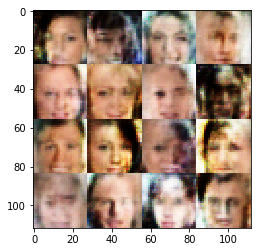

Epoch 1/1..., step 1610 Discriminator Loss: 0.2498... Generator Loss: 2.0388
Epoch 1/1..., step 1620 Discriminator Loss: 0.1274... Generator Loss: 3.3193
Epoch 1/1..., step 1630 Discriminator Loss: 1.4445... Generator Loss: 0.3359
Epoch 1/1..., step 1640 Discriminator Loss: 0.3757... Generator Loss: 1.4640
Epoch 1/1..., step 1650 Discriminator Loss: 0.3999... Generator Loss: 1.5951
Epoch 1/1..., step 1660 Discriminator Loss: 0.7649... Generator Loss: 2.6886
Epoch 1/1..., step 1670 Discriminator Loss: 0.5154... Generator Loss: 1.2075
Epoch 1/1..., step 1680 Discriminator Loss: 0.1800... Generator Loss: 4.6208
Epoch 1/1..., step 1690 Discriminator Loss: 0.1667... Generator Loss: 3.8571
Epoch 1/1..., step 1700 Discriminator Loss: 0.1812... Generator Loss: 2.8118


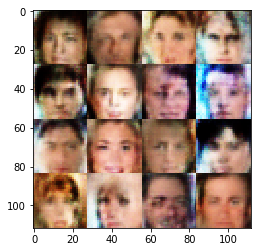

Epoch 1/1..., step 1710 Discriminator Loss: 0.6323... Generator Loss: 1.9137
Epoch 1/1..., step 1720 Discriminator Loss: 0.1456... Generator Loss: 4.1493
Epoch 1/1..., step 1730 Discriminator Loss: 0.2439... Generator Loss: 4.0128
Epoch 1/1..., step 1740 Discriminator Loss: 3.7537... Generator Loss: 0.0289
Epoch 1/1..., step 1750 Discriminator Loss: 0.5082... Generator Loss: 2.2055
Epoch 1/1..., step 1760 Discriminator Loss: 0.2530... Generator Loss: 2.0565
Epoch 1/1..., step 1770 Discriminator Loss: 1.9008... Generator Loss: 0.2205
Epoch 1/1..., step 1780 Discriminator Loss: 0.7276... Generator Loss: 1.0062
Epoch 1/1..., step 1790 Discriminator Loss: 0.1585... Generator Loss: 3.4080
Epoch 1/1..., step 1800 Discriminator Loss: 1.1957... Generator Loss: 1.1658


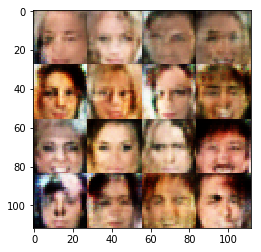

Epoch 1/1..., step 1810 Discriminator Loss: 1.1642... Generator Loss: 0.4896
Epoch 1/1..., step 1820 Discriminator Loss: 0.2596... Generator Loss: 4.1818
Epoch 1/1..., step 1830 Discriminator Loss: 0.1884... Generator Loss: 5.9673
Epoch 1/1..., step 1840 Discriminator Loss: 0.1106... Generator Loss: 3.2751
Epoch 1/1..., step 1850 Discriminator Loss: 0.2410... Generator Loss: 4.5128
Epoch 1/1..., step 1860 Discriminator Loss: 2.3162... Generator Loss: 2.1299
Epoch 1/1..., step 1870 Discriminator Loss: 1.2028... Generator Loss: 0.6854
Epoch 1/1..., step 1880 Discriminator Loss: 0.1803... Generator Loss: 3.7279
Epoch 1/1..., step 1890 Discriminator Loss: 0.9178... Generator Loss: 1.8370
Epoch 1/1..., step 1900 Discriminator Loss: 0.1631... Generator Loss: 3.0237


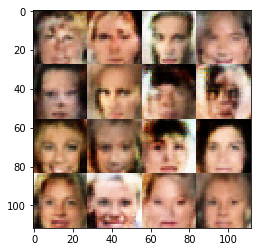

Epoch 1/1..., step 1910 Discriminator Loss: 0.6972... Generator Loss: 0.9729
Epoch 1/1..., step 1920 Discriminator Loss: 0.4182... Generator Loss: 1.6199
Epoch 1/1..., step 1930 Discriminator Loss: 0.2792... Generator Loss: 2.0167
Epoch 1/1..., step 1940 Discriminator Loss: 0.7078... Generator Loss: 0.8142
Epoch 1/1..., step 1950 Discriminator Loss: 0.4785... Generator Loss: 1.3531
Epoch 1/1..., step 1960 Discriminator Loss: 0.7854... Generator Loss: 3.0450
Epoch 1/1..., step 1970 Discriminator Loss: 1.6675... Generator Loss: 2.2073
Epoch 1/1..., step 1980 Discriminator Loss: 0.9535... Generator Loss: 0.7908
Epoch 1/1..., step 1990 Discriminator Loss: 0.8197... Generator Loss: 0.8434
Epoch 1/1..., step 2000 Discriminator Loss: 0.3362... Generator Loss: 3.1837


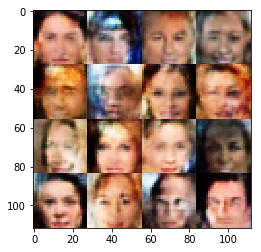

Epoch 1/1..., step 2010 Discriminator Loss: 0.2721... Generator Loss: 2.7066
Epoch 1/1..., step 2020 Discriminator Loss: 0.1632... Generator Loss: 4.2348
Epoch 1/1..., step 2030 Discriminator Loss: 0.1494... Generator Loss: 3.2232
Epoch 1/1..., step 2040 Discriminator Loss: 0.3961... Generator Loss: 1.4194
Epoch 1/1..., step 2050 Discriminator Loss: 0.1428... Generator Loss: 3.6962
Epoch 1/1..., step 2060 Discriminator Loss: 0.0959... Generator Loss: 3.9093
Epoch 1/1..., step 2070 Discriminator Loss: 4.5393... Generator Loss: 2.8512
Epoch 1/1..., step 2080 Discriminator Loss: 1.3498... Generator Loss: 0.7998
Epoch 1/1..., step 2090 Discriminator Loss: 0.3001... Generator Loss: 2.0449
Epoch 1/1..., step 2100 Discriminator Loss: 0.1288... Generator Loss: 3.2374


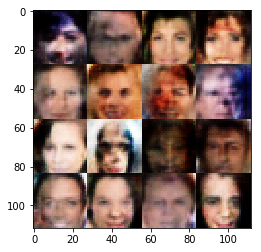

Epoch 1/1..., step 2110 Discriminator Loss: 0.1724... Generator Loss: 3.2020
Epoch 1/1..., step 2120 Discriminator Loss: 0.3241... Generator Loss: 6.4700
Epoch 1/1..., step 2130 Discriminator Loss: 0.9242... Generator Loss: 0.7441
Epoch 1/1..., step 2140 Discriminator Loss: 0.8946... Generator Loss: 2.9121
Epoch 1/1..., step 2150 Discriminator Loss: 0.6763... Generator Loss: 1.5401
Epoch 1/1..., step 2160 Discriminator Loss: 0.7232... Generator Loss: 0.9979
Epoch 1/1..., step 2170 Discriminator Loss: 1.3236... Generator Loss: 0.4187
Epoch 1/1..., step 2180 Discriminator Loss: 0.7083... Generator Loss: 0.9834
Epoch 1/1..., step 2190 Discriminator Loss: 0.2268... Generator Loss: 2.1085
Epoch 1/1..., step 2200 Discriminator Loss: 0.4835... Generator Loss: 1.3882


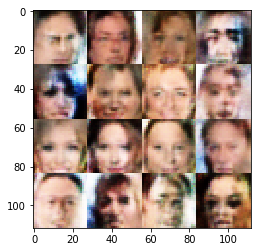

Epoch 1/1..., step 2210 Discriminator Loss: 0.9684... Generator Loss: 0.7128
Epoch 1/1..., step 2220 Discriminator Loss: 0.4855... Generator Loss: 2.4424
Epoch 1/1..., step 2230 Discriminator Loss: 0.6223... Generator Loss: 1.0757
Epoch 1/1..., step 2240 Discriminator Loss: 0.4399... Generator Loss: 1.3944
Epoch 1/1..., step 2250 Discriminator Loss: 0.1906... Generator Loss: 3.9053
Epoch 1/1..., step 2260 Discriminator Loss: 0.4155... Generator Loss: 1.5132
Epoch 1/1..., step 2270 Discriminator Loss: 0.3468... Generator Loss: 3.8022
Epoch 1/1..., step 2280 Discriminator Loss: 0.7914... Generator Loss: 4.2700
Epoch 1/1..., step 2290 Discriminator Loss: 0.8571... Generator Loss: 1.6820
Epoch 1/1..., step 2300 Discriminator Loss: 0.4047... Generator Loss: 1.8853


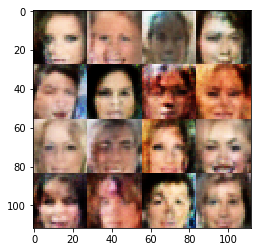

Epoch 1/1..., step 2310 Discriminator Loss: 0.2153... Generator Loss: 4.3508
Epoch 1/1..., step 2320 Discriminator Loss: 0.2715... Generator Loss: 2.5564
Epoch 1/1..., step 2330 Discriminator Loss: 0.2414... Generator Loss: 3.0092
Epoch 1/1..., step 2340 Discriminator Loss: 0.2859... Generator Loss: 1.8974
Epoch 1/1..., step 2350 Discriminator Loss: 0.9512... Generator Loss: 0.7807
Epoch 1/1..., step 2360 Discriminator Loss: 0.4868... Generator Loss: 1.1239
Epoch 1/1..., step 2370 Discriminator Loss: 0.1801... Generator Loss: 4.3926
Epoch 1/1..., step 2380 Discriminator Loss: 0.1773... Generator Loss: 4.2566
Epoch 1/1..., step 2390 Discriminator Loss: 0.3523... Generator Loss: 3.5150
Epoch 1/1..., step 2400 Discriminator Loss: 0.3154... Generator Loss: 2.9764


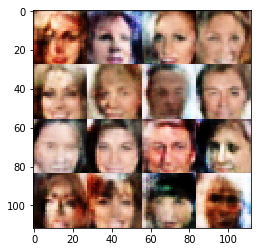

Epoch 1/1..., step 2410 Discriminator Loss: 0.5465... Generator Loss: 1.0854
Epoch 1/1..., step 2420 Discriminator Loss: 0.2076... Generator Loss: 2.2678
Epoch 1/1..., step 2430 Discriminator Loss: 0.1095... Generator Loss: 5.5520
Epoch 1/1..., step 2440 Discriminator Loss: 1.2201... Generator Loss: 0.6760
Epoch 1/1..., step 2450 Discriminator Loss: 1.1805... Generator Loss: 0.6926
Epoch 1/1..., step 2460 Discriminator Loss: 0.9962... Generator Loss: 0.8385
Epoch 1/1..., step 2470 Discriminator Loss: 0.6899... Generator Loss: 0.9962
Epoch 1/1..., step 2480 Discriminator Loss: 0.4751... Generator Loss: 1.4231
Epoch 1/1..., step 2490 Discriminator Loss: 0.3482... Generator Loss: 1.5394
Epoch 1/1..., step 2500 Discriminator Loss: 0.2048... Generator Loss: 3.2199


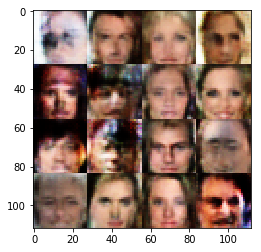

Epoch 1/1..., step 2510 Discriminator Loss: 0.4095... Generator Loss: 1.3466
Epoch 1/1..., step 2520 Discriminator Loss: 0.9358... Generator Loss: 0.8587
Epoch 1/1..., step 2530 Discriminator Loss: 0.9692... Generator Loss: 0.9141
Epoch 1/1..., step 2540 Discriminator Loss: 1.4358... Generator Loss: 0.3695
Epoch 1/1..., step 2550 Discriminator Loss: 0.2366... Generator Loss: 2.5421
Epoch 1/1..., step 2560 Discriminator Loss: 0.2343... Generator Loss: 1.9339
Epoch 1/1..., step 2570 Discriminator Loss: 1.3085... Generator Loss: 0.4865
Epoch 1/1..., step 2580 Discriminator Loss: 1.1366... Generator Loss: 0.9905
Epoch 1/1..., step 2590 Discriminator Loss: 0.7723... Generator Loss: 1.4107
Epoch 1/1..., step 2600 Discriminator Loss: 0.3201... Generator Loss: 1.6711


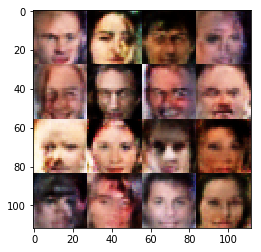

Epoch 1/1..., step 2610 Discriminator Loss: 0.5134... Generator Loss: 1.3101
Epoch 1/1..., step 2620 Discriminator Loss: 0.8099... Generator Loss: 1.3371
Epoch 1/1..., step 2630 Discriminator Loss: 0.9061... Generator Loss: 1.1920
Epoch 1/1..., step 2640 Discriminator Loss: 0.3104... Generator Loss: 2.6033
Epoch 1/1..., step 2650 Discriminator Loss: 1.5876... Generator Loss: 0.2977
Epoch 1/1..., step 2660 Discriminator Loss: 0.8820... Generator Loss: 0.8993
Epoch 1/1..., step 2670 Discriminator Loss: 1.8329... Generator Loss: 0.2847
Epoch 1/1..., step 2680 Discriminator Loss: 0.5609... Generator Loss: 2.3668
Epoch 1/1..., step 2690 Discriminator Loss: 0.1202... Generator Loss: 3.6429
Epoch 1/1..., step 2700 Discriminator Loss: 0.1639... Generator Loss: 3.2936


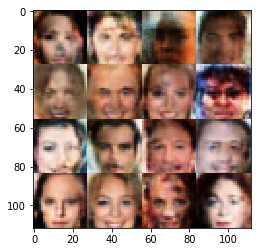

Epoch 1/1..., step 2710 Discriminator Loss: 0.3083... Generator Loss: 5.8661
Epoch 1/1..., step 2720 Discriminator Loss: 0.7956... Generator Loss: 1.0214
Epoch 1/1..., step 2730 Discriminator Loss: 0.7091... Generator Loss: 1.8299
Epoch 1/1..., step 2740 Discriminator Loss: 0.5791... Generator Loss: 1.2820
Epoch 1/1..., step 2750 Discriminator Loss: 0.9969... Generator Loss: 0.6751
Epoch 1/1..., step 2760 Discriminator Loss: 0.1133... Generator Loss: 2.9000
Epoch 1/1..., step 2770 Discriminator Loss: 0.2039... Generator Loss: 2.5094
Epoch 1/1..., step 2780 Discriminator Loss: 0.2487... Generator Loss: 2.1989
Epoch 1/1..., step 2790 Discriminator Loss: 1.0842... Generator Loss: 0.5107
Epoch 1/1..., step 2800 Discriminator Loss: 0.9452... Generator Loss: 0.8663


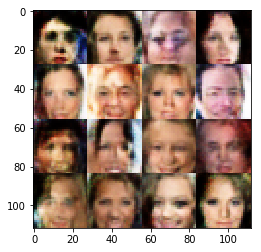

Epoch 1/1..., step 2810 Discriminator Loss: 1.1021... Generator Loss: 0.6266
Epoch 1/1..., step 2820 Discriminator Loss: 0.3556... Generator Loss: 1.7618
Epoch 1/1..., step 2830 Discriminator Loss: 0.5236... Generator Loss: 1.2168
Epoch 1/1..., step 2840 Discriminator Loss: 0.2292... Generator Loss: 2.3440
Epoch 1/1..., step 2850 Discriminator Loss: 0.7549... Generator Loss: 0.7677
Epoch 1/1..., step 2860 Discriminator Loss: 0.3242... Generator Loss: 2.0286
Epoch 1/1..., step 2870 Discriminator Loss: 0.3954... Generator Loss: 4.5712
Epoch 1/1..., step 2880 Discriminator Loss: 0.2437... Generator Loss: 2.2132
Epoch 1/1..., step 2890 Discriminator Loss: 0.8031... Generator Loss: 0.8267
Epoch 1/1..., step 2900 Discriminator Loss: 0.8908... Generator Loss: 1.1426


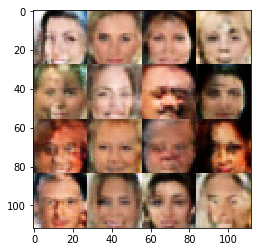

Epoch 1/1..., step 2910 Discriminator Loss: 0.9907... Generator Loss: 0.7162
Epoch 1/1..., step 2920 Discriminator Loss: 0.6008... Generator Loss: 1.1413
Epoch 1/1..., step 2930 Discriminator Loss: 0.8728... Generator Loss: 1.4523
Epoch 1/1..., step 2940 Discriminator Loss: 0.2029... Generator Loss: 3.6535
Epoch 1/1..., step 2950 Discriminator Loss: 0.4179... Generator Loss: 1.3487
Epoch 1/1..., step 2960 Discriminator Loss: 0.3991... Generator Loss: 3.0017
Epoch 1/1..., step 2970 Discriminator Loss: 0.3662... Generator Loss: 3.6160
Epoch 1/1..., step 2980 Discriminator Loss: 1.8850... Generator Loss: 0.2066
Epoch 1/1..., step 2990 Discriminator Loss: 0.7944... Generator Loss: 1.2682
Epoch 1/1..., step 3000 Discriminator Loss: 0.3708... Generator Loss: 1.7688


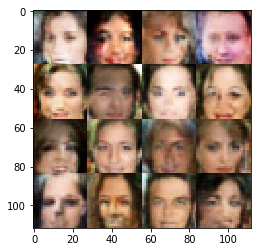

Epoch 1/1..., step 3010 Discriminator Loss: 0.2857... Generator Loss: 3.0436
Epoch 1/1..., step 3020 Discriminator Loss: 0.2364... Generator Loss: 2.7383
Epoch 1/1..., step 3030 Discriminator Loss: 0.3235... Generator Loss: 1.6481
Epoch 1/1..., step 3040 Discriminator Loss: 0.2565... Generator Loss: 5.0444
Epoch 1/1..., step 3050 Discriminator Loss: 0.1800... Generator Loss: 3.0133
Epoch 1/1..., step 3060 Discriminator Loss: 0.6032... Generator Loss: 1.6919
Epoch 1/1..., step 3070 Discriminator Loss: 0.8936... Generator Loss: 1.0409
Epoch 1/1..., step 3080 Discriminator Loss: 0.6823... Generator Loss: 1.1080
Epoch 1/1..., step 3090 Discriminator Loss: 1.2007... Generator Loss: 0.5603
Epoch 1/1..., step 3100 Discriminator Loss: 0.3147... Generator Loss: 1.8853


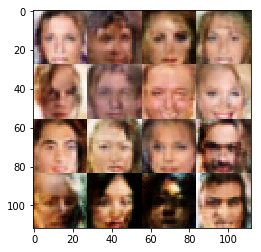

Epoch 1/1..., step 3110 Discriminator Loss: 0.8715... Generator Loss: 1.1788
Epoch 1/1..., step 3120 Discriminator Loss: 0.3929... Generator Loss: 2.4026
Epoch 1/1..., step 3130 Discriminator Loss: 0.5594... Generator Loss: 1.4855
Epoch 1/1..., step 3140 Discriminator Loss: 1.0132... Generator Loss: 1.0494
Epoch 1/1..., step 3150 Discriminator Loss: 1.0494... Generator Loss: 0.7280
Epoch 1/1..., step 3160 Discriminator Loss: 0.8602... Generator Loss: 1.1468


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.